# <span style="color:blue">  Movie Tweetings PySpark Recommender</span>


From the November 27th tweetings avaliable, the ratings and items data files will be loaded first into pandas and then converted to Spark dataframes. Both versions will be used for analysis and visualization purposes. 



In [1]:
import findspark
findspark.init('/usr/local/opt/apache-spark/libexec')
from pyspark import SparkContext
import pyspark
import pandas as pd

sc = pyspark.SparkContext(appName="spark based notebook")
#print sc


In [2]:
pdmovies = pd.read_csv('movies.dat', sep='::', header='infer', skipinitialspace=True,names = ["MovieId","Movie_Title","Genres"])
pdmovies = pdmovies.drop('Genres', 1)
pdmovies[['movie', 'year']] = pdmovies['Movie_Title'].str.split('(',expand=True)
pdmovies[['year', 'del']] = pdmovies['year'].str.split(')',expand=True)
pdmovies = pdmovies.drop('del', 1)
pdmovies = pdmovies.drop('Movie_Title', 1)
pdratings = pd.read_csv('ratings.dat', sep='::', header='infer', skipinitialspace=True,names = ["UserId", "MovieId", "Rating", "Timestamp"])
pdratings=pdratings.drop('Timestamp',1)

/Users/B.Patel@ibm.com/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/Users/B.Patel@ibm.com/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


In [3]:
import numpy as np
pdratings=pdratings.merge(pdmovies,on='MovieId',how='left')
pdratings["scaled"] = np.sign(pdratings.Rating - 5)
#print(pdratings)

The pandas dataframes are now converted to Spark dataframes using SQL Context.

In [4]:
from pyspark.sql import SQLContext
sqlCtx = SQLContext(sc)
ratings=sqlCtx.createDataFrame(pdratings)


# Exploratory Analysis & Visualization of Data

In [5]:
ratings.describe().show()

+-------+------------------+------------------+-----------------+---------+------------------+------------------+
|summary|            UserId|           MovieId|           Rating|    movie|              year|            scaled|
+-------+------------------+------------------+-----------------+---------+------------------+------------------+
|  count|            661041|            661041|           661041|   661041|            661041|            661041|
|   mean|25746.769123246515|1682644.1942859823|7.301606103101018| Infinity|2008.3000766972093|0.7817381977819833|
| stddev|14790.731994397118| 1261723.933614962|1.861220224723241|      NaN|12.648961199287482|0.5618353337379685|
|    min|                 1|                 8|                0|       $ |              1878|                -1|
|    max|             51713|           7659376|               10|Ãrestir |              2017|                 1|
+-------+------------------+------------------+-----------------+---------+-------------

In [6]:


print "Number of different users: " + str(ratings.select('userId').distinct().count())
print "Number of different movies: " + str(ratings.select('movieId').distinct().count())
print "Number of movies with at least one rating strictly less than 5: " + str(ratings.filter('rating < 5').select('movieId').distinct().count())
print "Number of movies with at least one rating 5 or greater : " + str(ratings.filter('rating >= 5').select('movieId').distinct().count())



Number of different users: 51713
Number of different movies: 29733
Number of movies with at least one rating strictly less than 5: 10230
Number of movies with at least one rating 5 or greater : 27234


In particular, we lack here a substantial number of ratings for items that are disliked by our users. This intuitively makes sense. Users may prefer to share their movie rating through Twitter if they enjoyed watching the film to allow their followers to know about a great movie. 


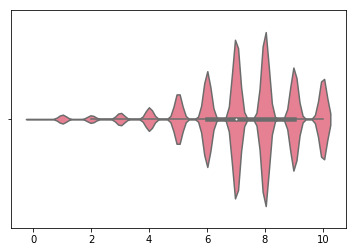

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.violinplot([pdratings.Rating],palette="husl")

We see here again that users tend to tweet structured tweets about movies they rate highly.

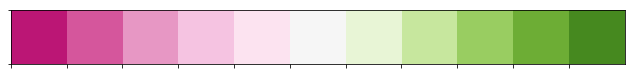

In [8]:
sns.palplot(sns.color_palette("PiYG", 11))


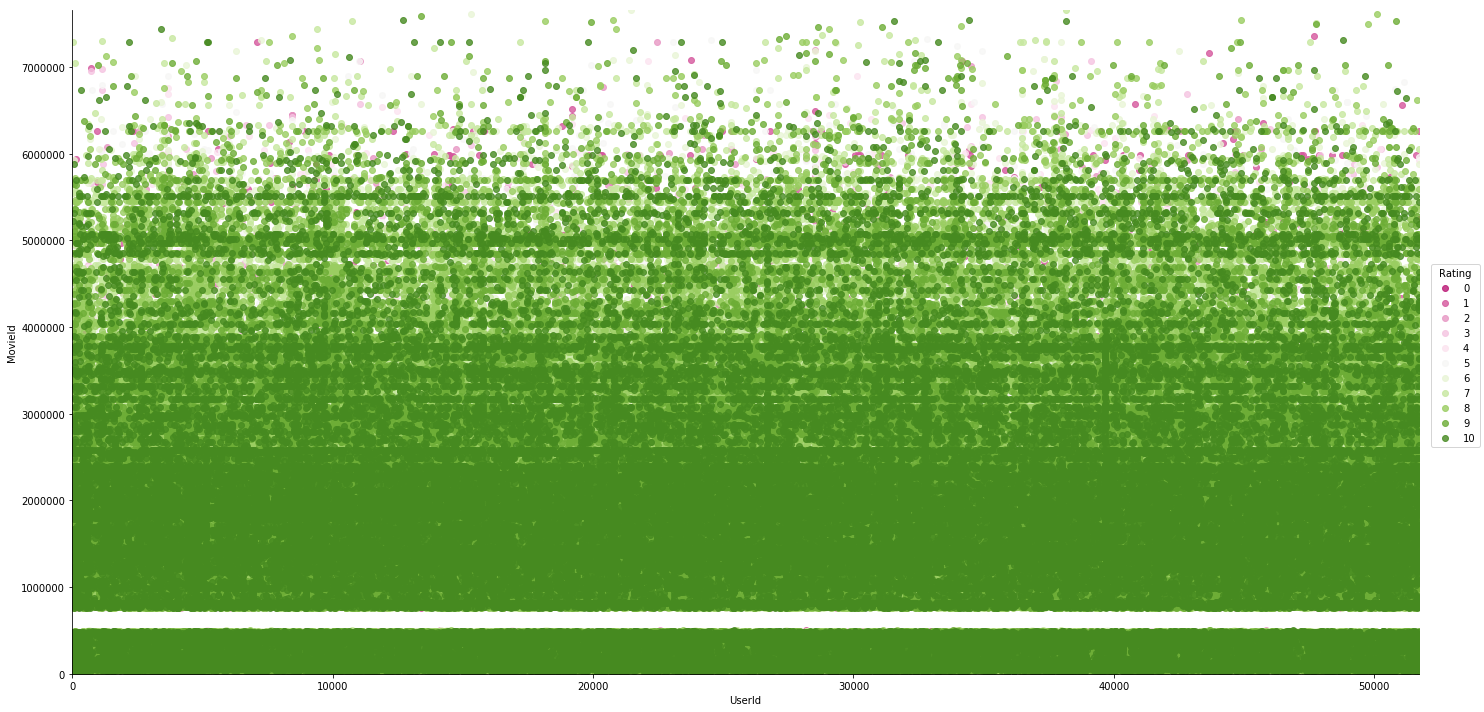

In [9]:


visualize = sns.lmplot(x='UserId', y='MovieId', hue='Rating', data=pdratings, size=10, aspect=2, palette=sns.color_palette("PiYG", 11),fit_reg=False)
axes = visualize.axes
axes[0,0].set_ylim(0,7659376) 
axes[0,0].set_xlim(0,51713) 
visualize

# <span style="color:#3498db">  Implicit Feedback Model v Explicit Ratings Model</span>

Assuming that the asymmetric nature of the ratings distribution arises because of an analog of voluntary response bias, or rather in this case voluntary tweet bias, we can test the ALS model when ratings are considered as an explicit rating versus whether this provides implicit feedback representing strength of opinion. 

# Implicit Feedback Model

The data is initially split into 80% training data and 20% test data. 

In [10]:
from pyspark.ml.recommendation import ALS
(trainingRatings, testRatings) = ratings.randomSplit([80.0, 20.0])
als = ALS(userCol="UserId", itemCol="MovieId", ratingCol="Rating",implicitPrefs=True,coldStartStrategy="drop")

ALSimplmodel = als.fit(trainingRatings)

In [11]:
imppredictions = ALSimplmodel.transform(testRatings)
imppredictions.show()

+------+-------+------+--------------------+----+------+-------------+
|UserId|MovieId|Rating|               movie|year|scaled|   prediction|
+------+-------+------+--------------------+----+------+-------------+
| 19343|  18051|     6|    The Kid Brother |1927|     1|  0.033030473|
| 46685|  46521|     8|        I vitelloni |1953|     1|   0.19236203|
| 14606|  46521|     8|        I vitelloni |1953|     1|   0.07654652|
| 29270|  46521|     8|        I vitelloni |1953|     1|  0.014155421|
| 30548|  46521|     5|        I vitelloni |1953|     0|  0.070639655|
| 22970|  48254|     6|      Killer's Kiss |1955|     1|  0.031611852|
| 19108|  48254|     8|      Killer's Kiss |1955|     1|  0.015127834|
| 32397|  64519|     4|      DoppelgÃ¤nger |1969|    -1|   0.03380905|
| 20386|  70355|     7|       Magnum Force |1973|     1|  0.018697204|
| 14701|  86927|     7|     Bachelor Party |1984|     1|  0.027263043|
| 45190|  86927|     5|     Bachelor Party |1984|     0|  0.033690337|
| 2677

In [12]:
imp=imppredictions.toPandas()
imp=imp.sort_values(by=['UserId', 'prediction'],ascending=False)

In [13]:
implicit_by_pred=imp.groupby('UserId').head(3).reset_index(drop=True)

In [14]:
test=testRatings.toPandas()
#test=test.sort_values(by=['UserId', 'Rating'],ascending=False)
#test=test.groupby('UserId').head(3).reset_index(drop=True)

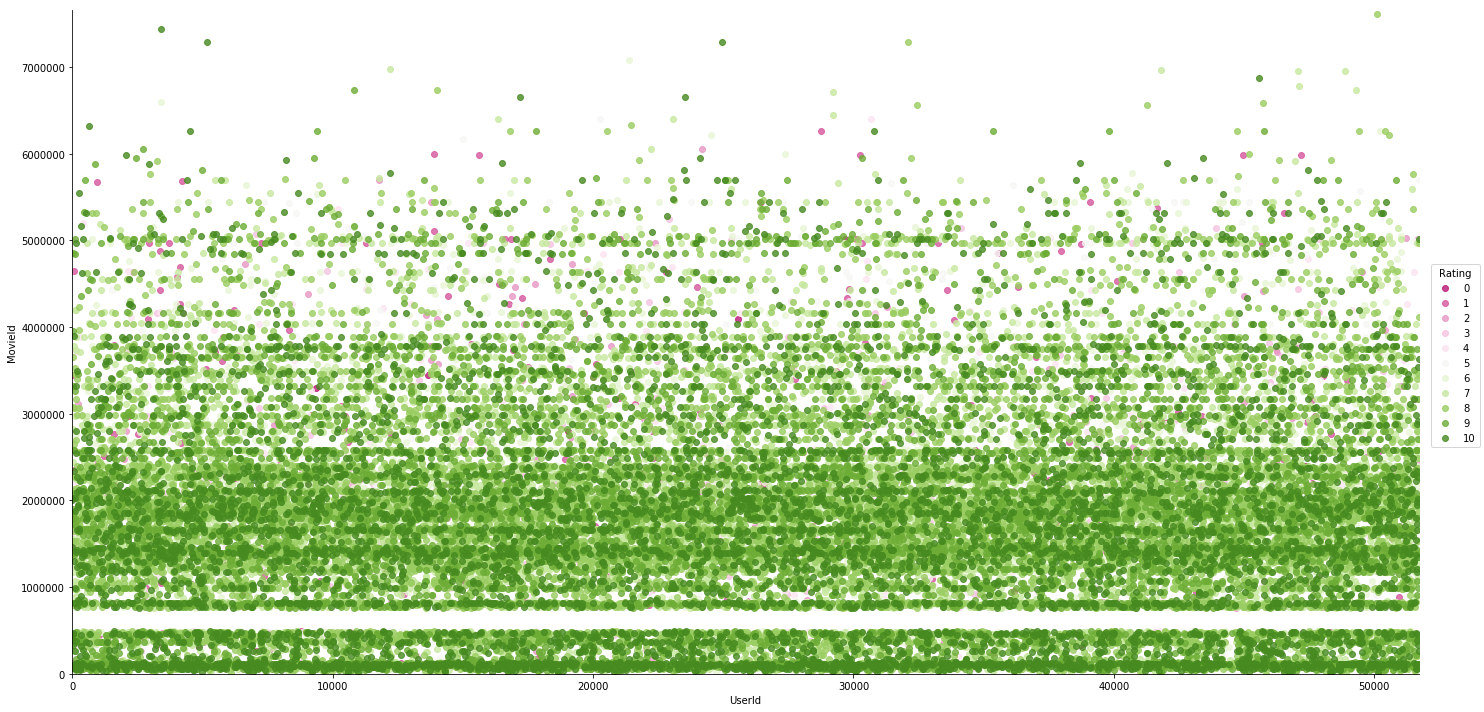

In [15]:
visualize = sns.lmplot(x='UserId', y='MovieId', hue='Rating', data=implicit_by_pred, size=10, aspect=2, palette=sns.color_palette("PiYG", 11),fit_reg=False)
axes = visualize.axes
axes[0,0].set_ylim(0,7659376) 
axes[0,0].set_xlim(0,51713) 
visualize

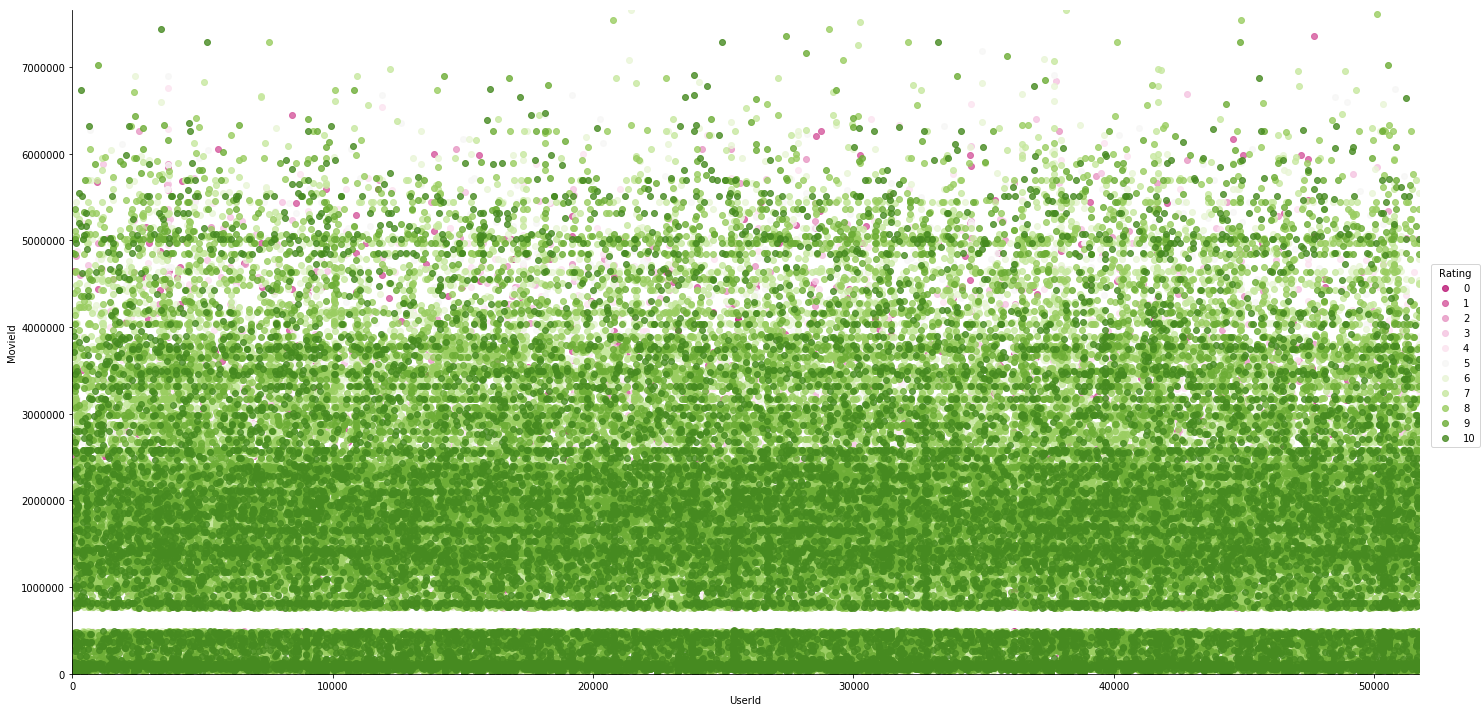

In [16]:
visualize = sns.lmplot(x='UserId', y='MovieId',hue='Rating', data=test, size=10, aspect=2, palette=sns.color_palette("PiYG", 11),fit_reg=False)
axes = visualize.axes
axes[0,0].set_ylim(0,7659376) 
axes[0,0].set_xlim(0,51713) 
visualize

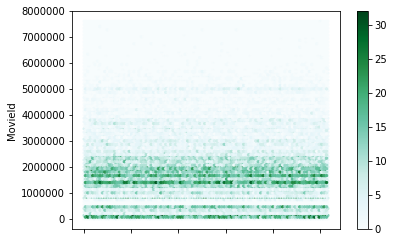

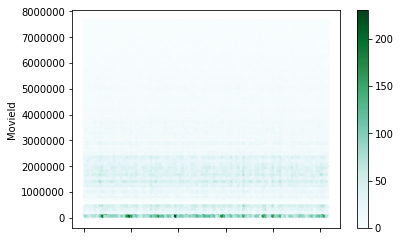

In [17]:
import numpy as np
import pylab as plt

#plt.scatter(UserId,MovieId,data=implicit_by_rating,color='k')
#plt.scatter(X,Y2,color='g')
#plt.show()

implicit_by_pred.plot(kind='hexbin', x='UserId', y='MovieId')
test.plot(kind='hexbin', x='UserId', y='MovieId')

The graphs above show that this implicit feedback model has given prediction value that correspond to the true top k=3 movies that individuals have rated and subsequently tweeted about. Spark does not have a metric calculator for precision and recall for such a model. Therefore, we will consider the metric of the percentage of missing ratings from the test data set from the predicted set. This can be extended to capture the idea of how many of the relevant movies are captured by the model--recall.

In [22]:
implicit_by_pred=implicit_by_pred.drop('prediction',1)


UserId  MovieId  Rating                                 movie  year  \
0       51713  2415464       2                      Hansel & Gretel   2013   
1       51711  3631112      10                The Girl on the Train   2016   
2       51711  4972582       8                                Split   2016   
3       51711  2872732       5                                 Lucy   2014   
4       51709  5013056      10                              Dunkirk   2017   
5       51709  4116284       8                The LEGO Batman Movie   2017   
6       51706   109830       8                         Forrest Gump   1994   
7       51706   407887       8                         The Departed   2006   
8       51706   264464      10                  Catch Me If You Can   2002   
9       51704  5700672       5                           Busanhaeng   2016   
10      51704  1878870       8                The Edge of Seventeen   2016   
11      51704   396171       9     Perfume: The Story of a Murderer   2006   
12      51699  1408101       1              Star Trek Into Darkness   2013   
13      51696  1411250       5                              Riddick   2013   
14      51696  1862079       7                Safety Not Guaranteed   2012   
15      51696   111161      10             The Shawshank Redemption   1994   
16      51693   993846       9              The Wolf of Wall Street   2013   
17      51693  2024544       9                     12 Years a Slave   2013   
18      51690  2015381      10              Guardians of the Galaxy   2014   
19      51690  3170832       9                                 Room   2015   
20      51690  2911666      10                            John Wick   2014   
21      51686  2305051       8                                 Wild   2014   
22      51686   107207       9            In the Name of the Father   1993   
23      51685  1535109       8                     Captain Phillips   2013   
24      51685  1343092      10                     The Great Gatsby   2013   
25      51685  1682180       7                               Stoker   2013   
26      51681    88847      10                   The Breakfast Club   1985   
27      51681   171804       5                       Boys Don't Cry   1999   
28      51681  1077368       7                         Dark Shadows   2012   
29      51675  2713180       9                                 Fury   2014   
...       ...      ...     ...                                   ...   ...   
42645      33  1340138       5                   Terminator Genisys   2015   
42646      33  3079380       8                                  Spy   2015   
42647      33  1502712       2                       Fantastic Four   2015   
42648      32  1300854       6                           Iron Man 3   2013   
42649      32  1588173       5                          Warm Bodies   2013   
42650      32  1636826       1                            Project X   2012   
42651      31  4857264       9                         Contratiempo   2016   
42652      31  3315342       9                                Logan   2017   
42653      31   106977       9                         The Fugitive   1993   
42654      26  3954660       9                               Suntan   2016   
42655      25   327056      10                         Mystic River   2003   
42656      25    88847       9                   The Breakfast Club   1985   
42657      25   795421       8                           Mamma Mia!   2008   
42658      24   816692       8                         Interstellar   2014   
42659      24  2820852       7                            Furious 7   2015   
42660      22  1170358       7  The Hobbit: The Desolation of Smaug   2013   
42661      22  2103281       8       Dawn of the Planet of the Apes   2014   
42662      22  2713180       6                                 Fury   2014   
42663      20  1549589       7                                Elles   2011   
42664      17    71562      1

In [30]:
test[~test.isin(implicit_by_pred)].count()


UserId     132185
MovieId    132125
Rating     125012
movie      132125
year       127534
scaled      99214
dtype: int64

In [28]:
total=implicit_by_pred.append(test).count()


In [32]:
((total-missing)/total)[0]

0.24405670789941725

We therefore see that there is approximately 75% recall.

# Explicit Ratings Model

In [45]:

(trainingRatings, testRatings) = ratings.randomSplit([90.0, 10.0])
als = ALS(userCol="UserId", itemCol="MovieId", ratingCol="Rating")
ALSmodel = als.fit(trainingRatings)

In [46]:
predictions = ALSmodel.transform(testRatings)
predictions.show()

+------+-------+------+--------------------+----+------+----------+
|UserId|MovieId|Rating|               movie|year|scaled|prediction|
+------+-------+------+--------------------+----+------+----------+
| 46685|   7880|     7|        Easy Street |1917|     1|   6.61074|
| 19756|  73091|     1|   The Happy Hooker |1975|    -1|       NaN|
|  3675|  83250|     4|Un dimanche de flic |1983|    -1|       NaN|
| 16754|  89537|     4|         Mala Noche |1986|    -1|       NaN|
| 35222|  89537|     7|         Mala Noche |1986|     1|       NaN|
| 51190|  92644|     7|Beverly Hills Cop...|1987|     1| 7.9288955|
| 41652|  92644|    10|Beverly Hills Cop...|1987|     1| 10.074417|
| 35679|  92644|     6|Beverly Hills Cop...|1987|     1| 5.4794226|
| 27028|  92644|     8|Beverly Hills Cop...|1987|     1|  6.778235|
| 18499|  93407|     7|     Less Than Zero |1987|     1| 6.3962884|
| 22384|  93407|     8|     Less Than Zero |1987|     1|  5.620873|
| 20681|  93407|     9|     Less Than Zero |1987

In [47]:
exp=predictions.toPandas()
exp=exp.sort_values(by=['UserId', 'prediction'],ascending=False)
explicit_by_pred=exp.groupby('UserId').head(3).reset_index(drop=True)

In [48]:
exp=exp.sort_values(by=['UserId', 'Rating'],ascending=False)
explicit_by_rating=exp.groupby('UserId').head(3).reset_index(drop=True)

(0, 51713)

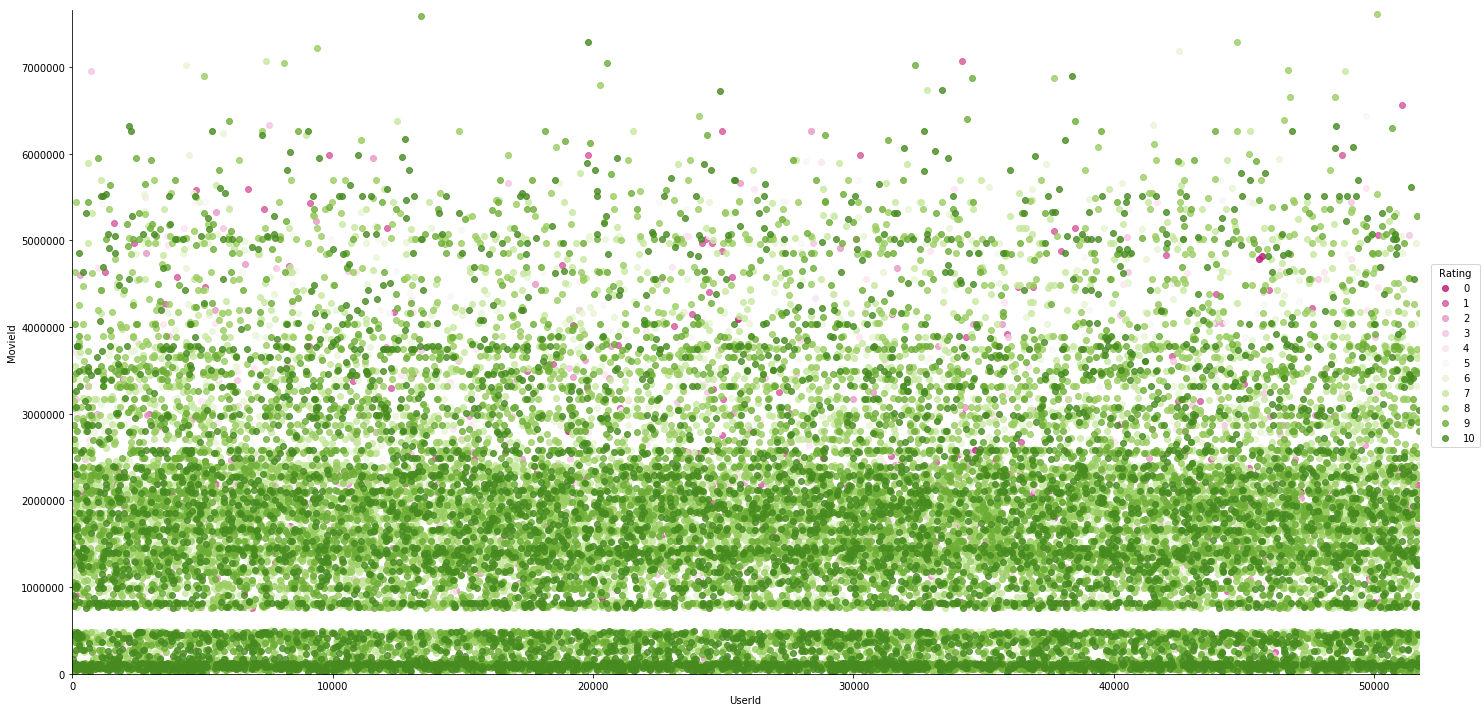

In [49]:
visualize = sns.lmplot(x='UserId', y='MovieId', hue='Rating', data=explicit_by_pred, size=10, aspect=2, palette=sns.color_palette("PiYG", 11),fit_reg=False)
axes = visualize.axes
axes[0,0].set_ylim(0,7659376) 
axes[0,0].set_xlim(0,51713) 
#visualize

(0, 51713)

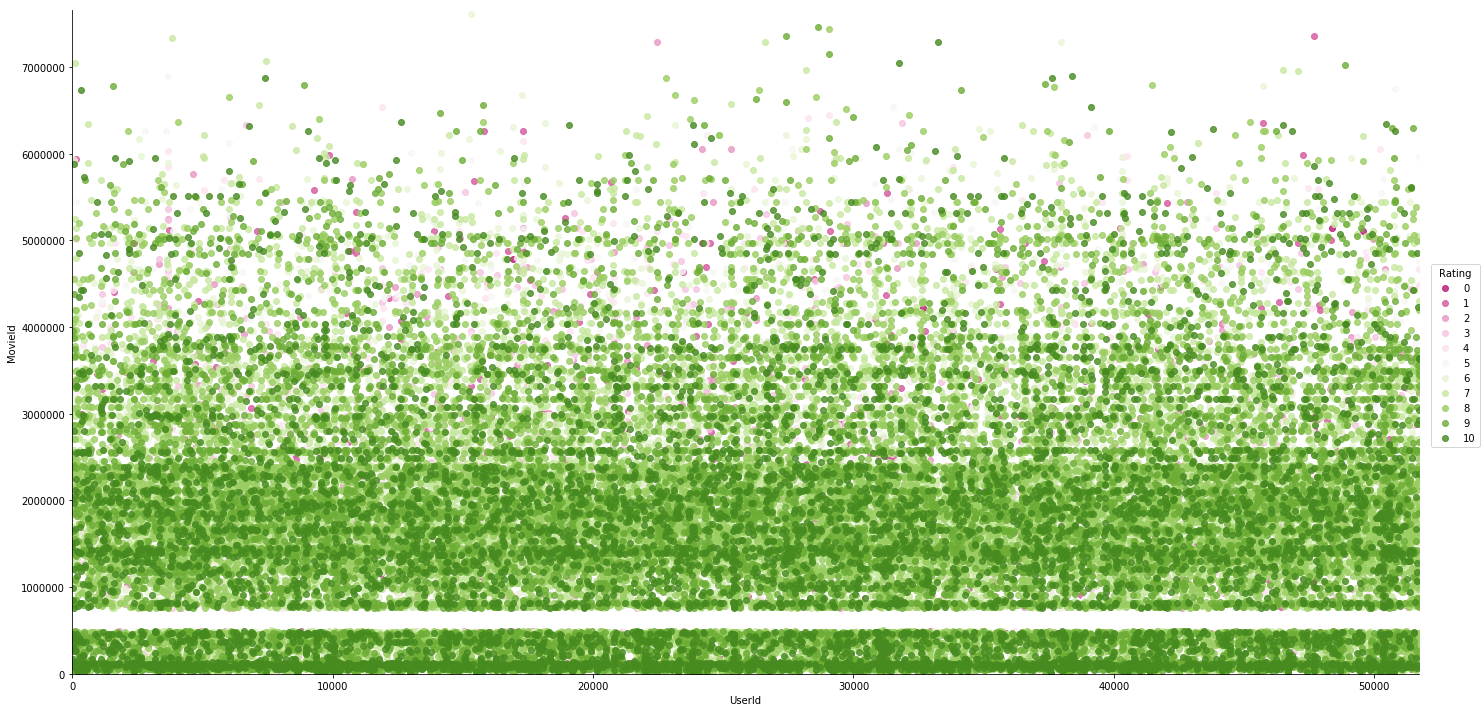

In [50]:
visualize = sns.lmplot(x='UserId', y='MovieId',hue='Rating', data=test, size=10, aspect=2, palette=sns.color_palette("PiYG", 11),fit_reg=False)
axes = visualize.axes
axes[0,0].set_ylim(0,7659376) 
axes[0,0].set_xlim(0,51713) 
#visualize

Now we will compare the model with a naive baseline that always returns the mean rating through RMSE.

In [51]:
test=testRatings.toPandas()
test['mean'] = test["Rating"].mean()
test['difference']=(test['Rating']-test['mean'])
test['difference']=test['difference']**2


In [52]:
baselinermse=test["difference"].mean()**.5
baselinermse

1.868404942821209

In [53]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating", predictionCol="prediction")
print "The root mean squared error for the model is: " + str(evaluator.evaluate(predictions))

The root mean squared error for the model is: nan


NaN results because the ALS model cannot predict ratings for users who have no ratings which is also known as the Cold Start problem. In this business case scenario we would still wish to predict recommendations for that user. Therefore, we elect to replace NaN values with the average rating and evaluate the model.

In [54]:
average = ratings.select('rating').groupBy().avg().first()[0]
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating", predictionCol="prediction")
testRMSE=(evaluator.evaluate(predictions.na.fill(average))) 
print "The root mean squared error for the model is: " + str(evaluator.evaluate(predictions.na.fill(average))) 


The root mean squared error for the model is: 1.64811092227


In [55]:
improvement = (baselinermse - testRMSE) / baselinermse * 100
improvement

11.790485857729156

There is an improvement over the naive model that rates every movie the average of movie ratings.  

# Tuning Hyperparamters for Explicit Ratings Model: Rank & the Regularization Parameter

The following hyperparamter modeling is computationally costly. A grid of parameter combinations is created a grid search is run over these respective combinations to compare their performance. The resulting model has an RMSE that is greater than the model above. 
Note: Because this is computationally costly, it may take several minutes to run.

In [56]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

(trainingRatings, validationRatings) = ratings.randomSplit([90.0, 10.0])
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating", predictionCol="prediction")

paramGrid = ParamGridBuilder()\
            .addGrid(als.rank, [5, 10])\
            .addGrid(als.maxIter, [10])\
            .addGrid(als.regParam, [.01,0.05, 0.1, 0.5])\
            .build()

crossval = CrossValidator(estimator=als, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)
cvModel = crossval.fit(trainingRatings)
predictions = cvModel.transform(validationRatings)

print "The root mean squared error for our model is: " + str(evaluator.evaluate(predictions.na.fill(average)))

The root mean squared error for our model is: 2.10955141855


The RMSE here is greater than that of the default ALS model: rank=10, maxIter=10, regParam=0.1. 

# Recommending New Movies

Our business seeks to drive its revenue growth by partnering with cinemas and theaters and providing new movie recommendations. We want to constrain the movies recommendations to those that have just hit the screens recently. We will therefore give the top recommendations for those movies that have been released within the last 2 years, capturing the market of theaters that stream movies for $2 that are between the box office and blu-ray avaliability as well as traditional theaters. For users where such a movie recommendation is not possible, we will recommend the most recent movies possible for them. 

The approach we undertake is essentially augmenting or constraining the explicit ratings model and only recommeding the top n=3 most recent movies. We will then check the perfomance of this model versus if we used a naive baseline that always returns the mean rating.

In [57]:
exp=exp.sort_values(by=['UserId', 'year', 'prediction'],ascending=False)


In [58]:
newmovies=exp.groupby('UserId').head(3).reset_index(drop=True)

In [59]:
newmovies['mean'] = newmovies["prediction"].mean()
newmovies['difference']=(newmovies['Rating']-newmovies['mean'])
newmovies['difference']=newmovies['difference']**2


In [60]:
newmoviesrmse=newmovies["difference"].mean()**.5
newmoviesrmse

1.9340026678475237

Now we will compare this to the naive model that will return the top 3 newest movies recommended for a user

In [61]:
test=testRatings.toPandas()

In [62]:
test['mean'] = test["Rating"].mean()
test=test.sort_values(by=['UserId', 'year', 'mean'],ascending=False)
test=test.groupby('UserId').head(3).reset_index(drop=True)
test['difference']=(test['Rating']-test['mean'])
test['difference']=test['difference']**2


In [63]:
test['difference']=(newmovies['Rating']-newmovies['mean'])
test['difference']=newmovies['difference']**2


In [64]:
baselinermse=test["difference"].mean()**.5
baselinermse

7.108147515730296

In [65]:
improvement = (baselinermse - newmoviesrmse) / baselinermse * 100
improvement

72.7917482921171

There is a roughly 3 fold improvement when predicting the top 3 new movies for a user with the explicit model versus the naive model. Intutively this makes sense, because the naive model will simply recommend the newest movies where the explicit rating model will consider the user's previous ratings. 